# ChatGLM3 Lora 实战

## ChatGLM介绍

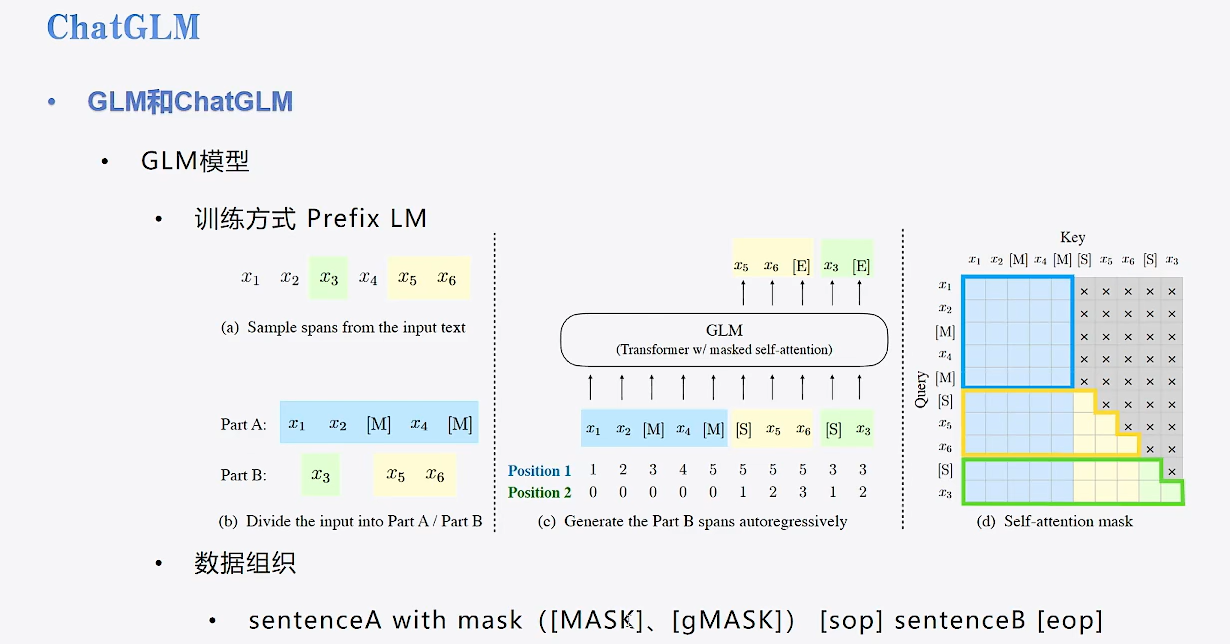

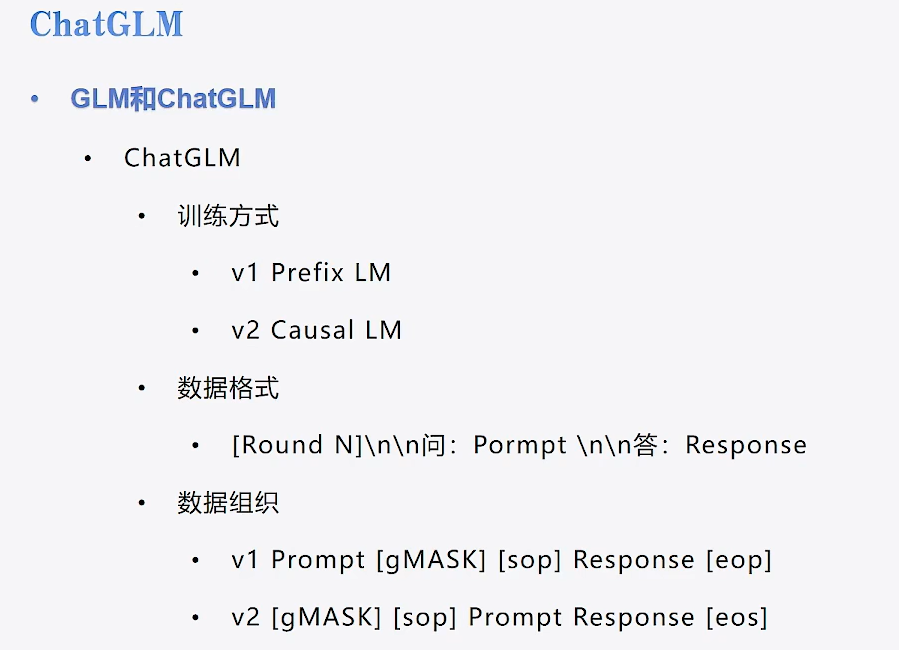

QA模型：要拆成两组数据

casual模型：一组数据就能训练

sop代表开始生成，eop结束生成

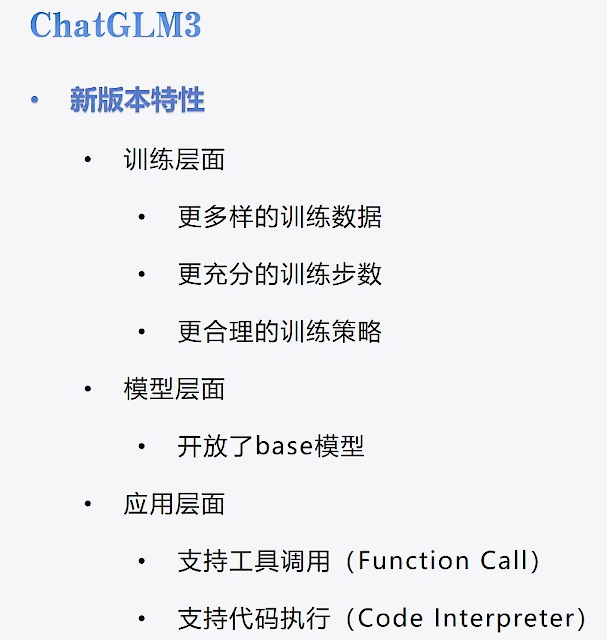

支持Agent工具调用：

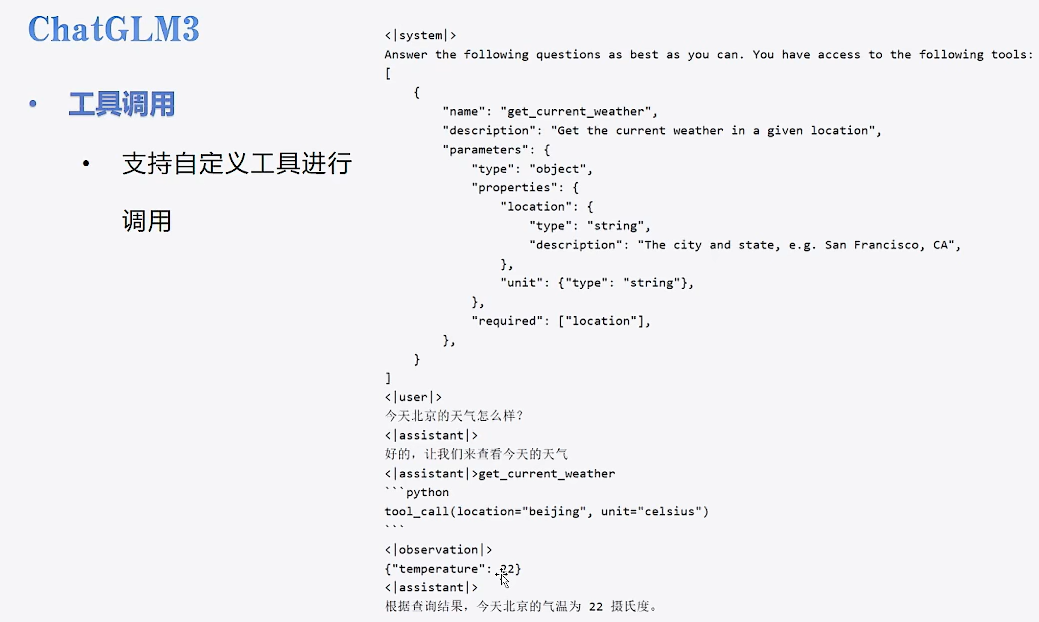

ChatGLM3对话头

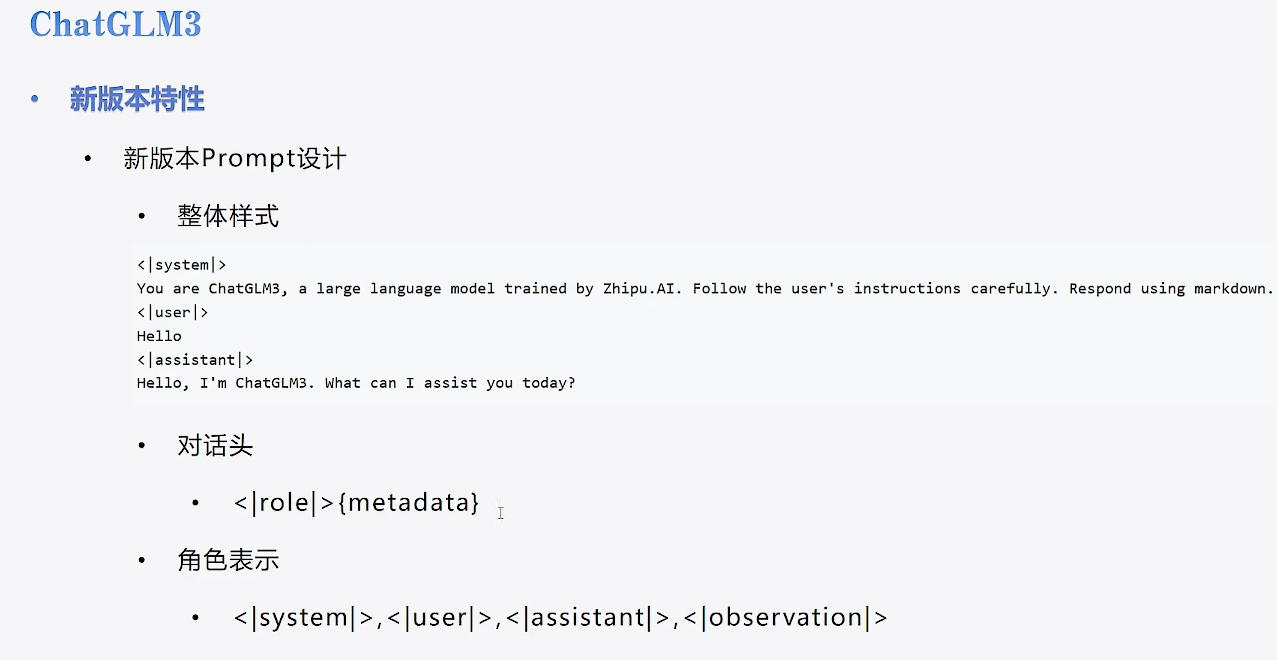

## 一个核心

获得这个模型的数据处理模板

## Step1 导入相关包

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
ds[:3]

{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
  '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'],
 'input': ['', '输入：4/16', ''],
 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}

## Step3 数据集预处理

In [3]:
tokenizer = AutoTokenizer.from_pretrained("/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base", trust_remote_code=True)
tokenizer

ChatGLMTokenizer(name_or_path='/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base', vocab_size=64798, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='left', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	
}

In [5]:
tokenizer(tokenizer.eos_token), tokenizer.eos_token_id

({'input_ids': [64790, 64792, 2893, 30917, 30994], 'attention_mask': [1, 1, 1, 1, 1], 'position_ids': [0, 1, 2, 3, 4]},
 2)

In [4]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []

    # query
    instruction = "\n".join([example["instruction"], example["input"]]).strip()     

    # tokenizer.build_chat_input
    # 就会构造出：[gMASK]sop<|user|> \n query<|assistant|>
    instruction = tokenizer.build_chat_input(instruction, history=[], role="user")  

    # response前面一定加\n
    # 加add_special_tokens=False是避免在response部分加上[gMASK]sop
    response = tokenizer("\n" + example["output"], add_special_tokens=False)        # \n response, 缺少eos token

    # 组装
    # 因为build_chat_inpu的input_ids是一个tensor，所以要变成list
    input_ids = instruction["input_ids"][0].numpy().tolist() + response["input_ids"] + [tokenizer.eos_token_id]
    attention_mask = instruction["attention_mask"][0].numpy().tolist() + response["attention_mask"] + [1] # 多一位
    labels = [-100] * len(instruction["input_ids"][0].numpy().tolist()) + response["input_ids"] + [tokenizer.eos_token_id]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Map:   0%|          | 0/26858 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [8]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

'[gMASK]sop<|user|> \n 解释为什么以下分数等同于1/4\n输入：4/16<|assistant|> \n4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。'

In [ ]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

## Step4 创建模型

In [6]:
import torch
model = AutoModelForCausalLM.from_pretrained("/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base", 
                                             trust_remote_code=True, 
                                             low_cpu_mem_usage=True, 
                                             torch_dtype=torch.bfloat16, 
                                             device_map="auto")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
for name, param in model.named_parameters():
    print(name)

transformer.embedding.word_embeddings.weight
transformer.encoder.layers.0.input_layernorm.weight
transformer.encoder.layers.0.self_attention.query_key_value.weight
transformer.encoder.layers.0.self_attention.query_key_value.bias
transformer.encoder.layers.0.self_attention.dense.weight
transformer.encoder.layers.0.post_attention_layernorm.weight
transformer.encoder.layers.0.mlp.dense_h_to_4h.weight
transformer.encoder.layers.0.mlp.dense_4h_to_h.weight
transformer.encoder.layers.1.input_layernorm.weight
transformer.encoder.layers.1.self_attention.query_key_value.weight
transformer.encoder.layers.1.self_attention.query_key_value.bias
transformer.encoder.layers.1.self_attention.dense.weight
transformer.encoder.layers.1.post_attention_layernorm.weight
transformer.encoder.layers.1.mlp.dense_h_to_4h.weight
transformer.encoder.layers.1.mlp.dense_4h_to_h.weight
transformer.encoder.layers.2.input_layernorm.weight
transformer.encoder.layers.2.self_attention.query_key_value.weight
transformer.enco

## Lora

### PEFT Step1 配置文件

In [7]:
from peft import LoraConfig, TaskType, get_peft_model, PeftModel

config = LoraConfig(target_modules=["query_key_value"], modules_to_save=["post_attention_layernorm"]) # 没有指定task_type
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=None, inference_mode=False, r=8, target_modules={'query_key_value'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=['post_attention_layernorm'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False)

### PEFT Step2 创建模型

In [8]:
model = get_peft_model(model, config)

In [13]:
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='/data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base', revision=None, task_type=None, inference_mode=False, r=8, target_modules={'query_key_value'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=['post_attention_layernorm'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False)

In [ ]:
for name, parameter in model.named_parameters():
    print(name)

In [14]:
model.print_trainable_parameters()

trainable params: 2,064,384 || all params: 6,245,648,384 || trainable%: 0.03305315754387495


In [ ]:
model

## Step5 配置训练参数

In [9]:
args = TrainingArguments(
    output_dir="./my-chatglm",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    logging_steps=10,
    num_train_epochs=1,
    learning_rate=1e-4,
    remove_unused_columns=False, # 重要，peft加载参数的逻辑，在没有指定task的时候
    save_steps=20,
    # save_strategy="epoch"
)

## Step6 创建训练器

In [10]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds.select(range(6000)),
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Step7 模型训练

In [11]:
trainer.train()

Step,Training Loss
10,1.912500
20,1.832000
30,1.781000
40,1.753700
50,1.565500
60,1.621000
70,1.583300
80,1.597200
90,1.611800
100,1.657800


/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /data1/zhengnanyan/huggingface/modelscope/ZhipuAI/chatglm3-6b-base - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=187, training_loss=1.6438925024022393, metrics={'train_runtime': 494.304, 'train_samples_per_second': 12.138, 'train_steps_per_second': 0.378, 'total_flos': 2.14874878758912e+16, 'train_loss': 1.6438925024022393, 'epoch': 1.0})

In [13]:
from safetensors import safe_open

with safe_open("./my-chatglm/checkpoint-187/adapter_model.safetensors", framework="pt") as f:
    for key in f.keys():
        if ".0.post_attention_layernorm" in key:
            print(key)
            print(f.get_tensor(key))

base_model.model.transformer.encoder.layers.0.post_attention_layernorm.weight
tensor([0.1543, 0.1533, 0.1572,  ..., 0.1553, 0.1572, 0.1533],
       dtype=torch.bfloat16)


## Step8 模型推理

In [14]:
model.eval()
print(model.chat(tokenizer, "数学考试怎么考高分？", history=[])[0])

数学考试要考高分，需要掌握以下几个方面：

1. 牢固掌握基础知识：数学的基础知识是学习数学的基础，掌握基础知识是解题的关键。

2. 练习解题：数学考试需要解题，解题需要通过大量的练习来提高解题能力。

3. 善于总结：总结解题过程中出现的错误和不足，总结出自己的解题方法和思路，以便更好地应对考试。

4. 熟悉考试题型：了解考试题型，掌握每种题型的解题思路和解题技巧，可以更好地应对考试。

5. 保持良好的心态：考试时保持良好的心态，不要紧张，相信自己的能力，相信自己可以考出好成绩。

以上是数学考试考高分的一些建议，希望对你有所帮助。
